In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import os
import pathlib
# tensorflow 2.

#from tensorflow import keras

# Run in anaconda prompt first:
# conda install -c conda-forge librosa
import librosa
import librosa.display

#from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Make sure you have the following files in the same directory as this ipynb:
# 1. nsynth-test.tfrecord
# 2. nsynth-train.tfrecord
# 3. nsynth-valid.tfrecord

nsynth_test = tf.data.TFRecordDataset(['nsynth-test.tfrecord'], num_parallel_reads=2)
nsynth_train = tf.data.TFRecordDataset(['nsynth-train.tfrecord'], num_parallel_reads=2)
nsynth_valid = tf.data.TFRecordDataset(['nsynth-valid.tfrecord'], num_parallel_reads=2)

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [3]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord#read_the_tfrecord_file

def get_features(record):
    # We're only going to use a few features for now
    features = {
        # identifier string, this will be our label
        #"note_str": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        # MIDI tuning standard value for pitch
        "pitch": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        # list of normalized audio 'samples' to represent the sound wave
        "audio": tf.io.FixedLenFeature(shape=[64000], dtype=tf.float32)
    }
    sample = tf.io.parse_single_example(record, features)
    
    return sample

In [4]:
test_ds = list(nsynth_test.take(1000).map(get_features))

In [5]:
# Note about how our audio feature is structured:
#
# 4 seconds * 16000 samples per second = 64000 samples
# We only have one channel (these sound clips are mono)
# Dynamic range of 16-bit PCM WAV (-2^15, 2^15 - 1) normalized to (-1, 1)


# We get the first sample in our test dataset as an example
clip1 = test_ds[0]['audio']
clip1

<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([ 3.8138387e-06, -3.8721851e-06,  3.9331076e-06, ...,
       -3.6526076e-06,  3.7041993e-06, -3.7578957e-06], dtype=float32)>

In [6]:
# temporarily borrowing code just for demonstration purposes

def midi_pitch_to_frequency(d):
    return (2**((d-69)/12.0))*440.0

from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def frequency_to_note(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

def midi_pitch_to_note(d):
    return frequency_to_note(midi_pitch_to_frequency(d))

f = midi_pitch_to_frequency(100)
print("Frequency: ", f)
print("Note: ", frequency_to_note(f))

Frequency:  2637.02045530296
Note:  E7


In [7]:
test_note = test_ds[0]['pitch']
test_note
# We can observe a few things from the previous 3 results:

# 1. Our first audio clip has midi pitch value 100, which encodes the note E7. 
# 2. The note E7 has the fundamental frequency 2637 Hz.
# 3. The spectogram above has frequency ~2700 Hz most represented.

<tf.Tensor: shape=(), dtype=int64, numpy=100>

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/signal/mfccs_from_log_mel_spectrograms
# https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

def to_mfccs(audio_array):
    return librosa.feature.mfcc(audio_array, sr=sample_rate, n_mfcc=40)#.flatten()

"""
def manual_convert_to_mfccs(audio_tensor):
    sample_rate = 16000
    # A 1024-point STFT with frames of 64 ms and 75% overlap.
    stfts = tf.signal.stft(audio_tensor, frame_length=1024, frame_step=256, fft_length=1024)
    spectrograms = tf.abs(stfts)

    # convert spectrograms to mel-scale
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    # most researchers use 13-20 cepstral coefficients for speech recognition
    # we'll start with that for now (to reduce feature space)
    num_mfcc = 20
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfcc] 
    
    # flatten 2D tensor
    return tf.reshape(mfccs, [-1])

clip1_mfccs = convert_to_mfccs(clip1)
clip1_mfccs
"""
# result: we go from 64,000 samples to 247x20 coefficients. 
# huge reduction in feature space!

"\ndef manual_convert_to_mfccs(audio_tensor):\n    sample_rate = 16000\n    # A 1024-point STFT with frames of 64 ms and 75% overlap.\n    stfts = tf.signal.stft(audio_tensor, frame_length=1024, frame_step=256, fft_length=1024)\n    spectrograms = tf.abs(stfts)\n\n    # convert spectrograms to mel-scale\n    num_spectrogram_bins = stfts.shape[-1]\n    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80\n    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(\n      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)\n    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)\n    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(\n      linear_to_mel_weight_matrix.shape[-1:]))\n\n    # get log-magnitude mel-scale spectrograms.\n    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)\n\n    # Compute MFCCs from log_mel_spectrograms\n    # most researchers use 13-20 cepstral coef

In [9]:
# Trim 289,205 training samples down to 20,000
# Too many samples takes too long to load and uses a lot of RAM
train_ds = list(nsynth_train.take(20000).map(get_features))

In [10]:
sample_rate = 16000
# We trimmed 4096 test samples down to 1000 
y_test = [test_ds[i]['pitch'].numpy() for i in range(len(test_ds))]
x_test = [to_mfccs(test_ds[i]['audio'].numpy()) for i in range(len(test_ds))]
#x_test = [convert_to_mfccs(test_ds[i]['audio']).numpy() for i in range(len(test_ds))]

y_train = [train_ds[i]['pitch'].numpy() for i in range(len(train_ds))]
x_train = [to_mfccs(train_ds[i]['audio'].numpy()) for i in range(len(train_ds))]
#x_train = [convert_to_mfccs(train_ds[i]['audio']).numpy() for i in range(len(train_ds))]

(40, 126)

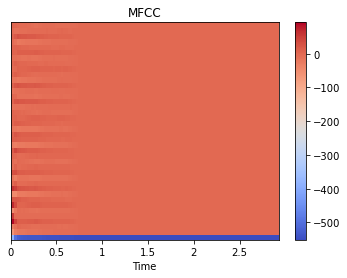

In [11]:
fig, ax = plt.subplots()
img = librosa.display.specshow(x_train[0], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')
x_train[0].shape

In [12]:
from numpy import newaxis
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train1 = x_train[:, :, :, newaxis]
x_train1[0].shape

(40, 126, 1)

In [32]:
input_shape = x_train1[0].shape

print('Input shape:', input_shape)
num_labels = 127

norm_layer = preprocessing.Normalization()
norm_layer.adapt(x_train)

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,  
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (40, 126, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 126)       253       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        36320     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)         

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [35]:
val_ds = list(nsynth_valid.take(1000).map(get_features))

sample_rate = 16000
# We trimmed 4096 test samples down to 1000 
y_val = [val_ds[i]['pitch'].numpy() for i in range(len(val_ds))]
x_val = [to_mfccs(val_ds[i]['audio'].numpy()) for i in range(len(val_ds))]

In [36]:
x_val = np.array(x_val)
y_val = np.array(y_val)
x_val1 = x_val[:, :, :, newaxis]
x_val1[0].shape

(40, 126, 1)

In [37]:
EPOCHS = 10
history = model.fit(
    x_train1, 
    y_train, 
    validation_data= (x_val1, y_val),  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
625/625 [==============================] - 129s 207ms/step - loss: 3.0963 - accuracy: 0.2711 - val_loss: 2.2581 - val_accuracy: 0.4500
Epoch 2/10
625/625 [==============================] - 123s 197ms/step - loss: 1.9787 - accuracy: 0.4491 - val_loss: 2.0672 - val_accuracy: 0.5120
Epoch 3/10
625/625 [==============================] - 113s 181ms/step - loss: 1.6761 - accuracy: 0.5073 - val_loss: 2.4507 - val_accuracy: 0.4310
Epoch 4/10
625/625 [==============================] - 114s 182ms/step - loss: 1.5172 - accuracy: 0.5393 - val_loss: 1.9039 - val_accuracy: 0.5280
Epoch 5/10
625/625 [==============================] - 119s 190ms/step - loss: 1.4084 - accuracy: 0.5645 - val_loss: 1.5138 - val_accuracy: 0.5930
Epoch 6/10
625/625 [==============================] - 112s 178ms/step - loss: 1.3028 - accuracy: 0.5943 - val_loss: 1.7721 - val_accuracy: 0.5550
Epoch 7/10
625/625 [==============================] - 117s 187ms/step - loss: 1.2248 - accuracy: 0.6136 - val_loss: 1.5560 -

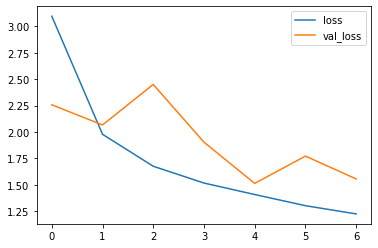

In [38]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [39]:
x_test = np.array(x_test)
y_test = np.array(y_test)

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 62%


In [43]:

from sklearn.metrics import confusion_matrix, classification_report

cnn_cm = confusion_matrix(y_test, y_pred)
mycolumns = ["Target: " + midi_pitch_to_note(i) for i in range(10,109)]
myindices = ["Predict: " + midi_pitch_to_note(i) for i in range(10,109)]
cnn_cm_df = pd.DataFrame(cnn_cm, index=myindices, columns=mycolumns)
cnn_cm_df

,Target: A#-1,Target: B-1,Target: C0,Target: C#0,Target: D0,Target: D#0,Target: E0,Target: F0,Target: F#0,Target: G0,...,Target: D#7,Target: E7,Target: F7,Target: F#7,Target: G7,Target: G#7,Target: A7,Target: A#7,Target: B7,Target: C8
Predict: A#-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: B-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: C0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: C#0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predict: D0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Predict: G#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
Predict: A7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,0,0,0
Predict: A#7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
Predict: B7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         2
          21       0.04      0.10      0.06        10
          22       0.00      0.00      0.00         8
          23       0.25      0.08      0.12        12
          24       0.00      0.00      0.00         7
          25       0.03      0.17      0.05         6
          26       0.00      0.00      0.00         9
          27       0.00    

/Users/cameronhudson/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After initial rounds of testing, Documented testing took place:

Trail 1:
* Train 20,000 samples
* Test 1,000 samples
* Validation 5,000 samples
* With Early Stopping
* Ran 3 EPOCHS with Accuracy of 58%
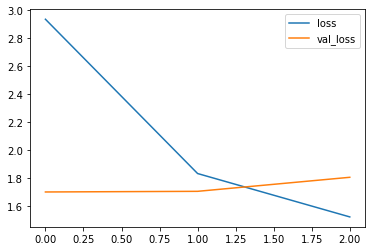

Trail 2:
* Train 20,000 samples
* Test 1,000 samples
* Validation 5,000 samples
* With NO Early Stopping
* ~20 minutes to train model
* Ran 3 EPOCHS with Accuracy of 61%
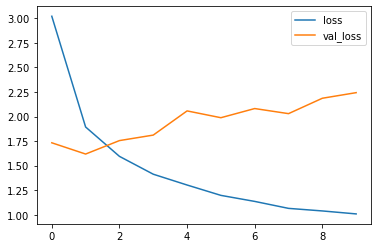

Trail 3:
* Train 20,000 samples
* Test 1,000 samples
* Validation 1,000 samples
* With Early Stopping
* ~14 minutes to train model
* Ran 7 EPOCHS with Accuracy of 62%
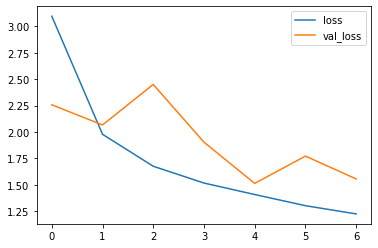